# Forecasting


In [47]:
import warnings
warnings.filterwarnings('ignore')
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sysidentpy.metrics import root_relative_squared_error

from prophet import Prophet
from neuralprophet import NeuralProphet


In [41]:
""" Root Relative Squared Error """
# Doesn't work!?
def rrse(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_true - y_pred)) / np.sum(np.square(y_true - np.mean(y_true))))

In [3]:
countries = {"Germany": "de", "Spain": "es", "France": "fr", "India": "in", "Italy": "it", "Russia": "ru", "Turkey": "tr", "United States": "us"}
country_list = list(countries.keys())
country_iso_code_list = list(countries.values())
data_type_list = ["confirmed_cases", "recovered_cases", "death_cases", "active_cases"]

# Forecasting using Facebook Prophet

# Forecasting for different types of cases for each country

In [59]:
def fbprophet_forecasting(country, country_code, data_type, start_date, end_date, split_date, results_table):
    df = pd.read_csv("data/data20_q1/" + country_code + "_" + data_type + ".csv")
    df["ds"] = pd.to_datetime(df["ds"])
    # print(df.info())

    period = (df['ds'] >= start_date) & (df['ds'] <= end_date)
    df = df.loc[period]

    plt.figure(figsize=(25, 10))
    plt.plot(df.groupby("ds")[["y"]].sum())
    plt.title(country + " - " + data_type.split("_")[0] + " cases")
    plt.xlabel("Date")
    plt.ylabel("Number of cases")
    plt.savefig("/home/vladimir/GoogleDrive/Courses/03Third_semester/projects/dsa-project/data/images/" + country.lower() + "_" + data_type + ".png")
    # print(plt.show())

    # Fit Prophet model
    train = df.loc[df["ds"] < split_date]
    test = df.loc[df["ds"] >= split_date]
    # print("Train size = %d, test size = %d" % (len(train), len(test)))

    model = Prophet()
    if (country == "United States"):
        ;
    else:
        model.add_country_holidays(country_name=country)
    model.fit(train)
    forecast = model.predict(test)
    fig = model.plot(forecast, figsize=(25, 10))
    fig.savefig("/home/vladimir/GoogleDrive/Courses/03Third_semester/projects/dsa-project/data/images/" + country.lower() + "_" + data_type + "_forecast.png")
    # print(fig)

    MAE = mean_absolute_error(y_true=test["y"], y_pred=forecast["yhat"])
    RMSE = math.sqrt(mean_squared_error(y_true=test["y"], y_pred=forecast["yhat"]))
    # RRSE = rrse(y_true=test["y"], y_pred=forecast["yhat"])
    RRSE = root_relative_squared_error(np.array(test["y"]), np.array(forecast["yhat"]))
    MAPE = mean_absolute_percentage_error(y_true=test["y"], y_pred=forecast["yhat"]) * 100
    # print(country.upper() + " | " + data_type)
    # print("MAE:", MAE)
    # print("RMSE:", RMSE)
    # print("RRSE:", RRSE)
    # print("MAPE", MAPE, "%")

    res = pd.DataFrame({"Country" : country, "Model"  : "Facebook Prophet", "MAE"  : round(MAE, 3), "RMSE" : round(RMSE, 3), "RRSE" : round(RRSE, 3), "MAPE" : round(MAPE, 3)}, index=[len(results_table)])
    results_table = pd.concat([results_table, res])
    return results_table

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.03569
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2297.1    0.00991459       1290.63      0.7343      0.7343      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2442.87    0.00632014       1419.41           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2559.08     0.0100555       3872.47           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2581.08   0.000109547       241.441           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2597.08    0.00515611       514.905      0.4375           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.64372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2069.47    0.00932494       600.144           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2112.89     0.0190253       436.379           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2130.18    0.00131643       317.248       1.958      0.1958      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2138.69   0.000739688       472.582      0.3356      0.3356      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     416       2141.44   0.000340337       286.264   2.107e-06       0.001      531  LS failed, Hessian reset 
     495       2145.67   9.85268e-05    

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.83746
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2260.23     0.0469864       1754.33      0.9173      0.9173      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2499.06     0.0662416       5325.86           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2639.61    0.00372451          2824      0.4736           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2783.31    0.00912261       3787.07           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2852.09    0.00122348       1270.63           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.2519
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2243.73       0.01083       3414.95           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2359.4    0.00377428       1242.12      0.4713           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2411.15   0.000813237       1074.55      0.3821      0.3821      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2442.11   0.000507158       276.568      0.4922           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2465.08    0.00200289       409.609           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.99058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2228.7    0.00984446       700.984           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2394.84     0.0111662       1249.26           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2485.96    0.00256456        768.84      0.4496      0.4496      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2528.89   0.000340078       385.102           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2544.68    0.00843009       372.341      0.4303           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.89194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2742.82      0.208268       10189.2           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3109.95     0.0114899       5887.24           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3169.82     0.0016508       4930.73           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3190.39   0.000838371       1420.46      0.8856      0.8856      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       3200.52     0.0014184       1543.48      0.1107           1      576   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.1423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1757.25     0.0775652       559.639           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1901.99     0.0117187       1624.45           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1980.26     0.0246934       488.681           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2010.29    0.00016164       891.553     0.09372     0.09372      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2032.49    0.00205861       337.273           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1992.62     0.0145001       2922.41      0.4041      0.4041      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2217.07     0.0112762       1432.88      0.2312           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2314.59     0.0186088       1245.88           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2520.06    0.00882338       1484.48           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2662.69   0.000592852       1205.27           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha   

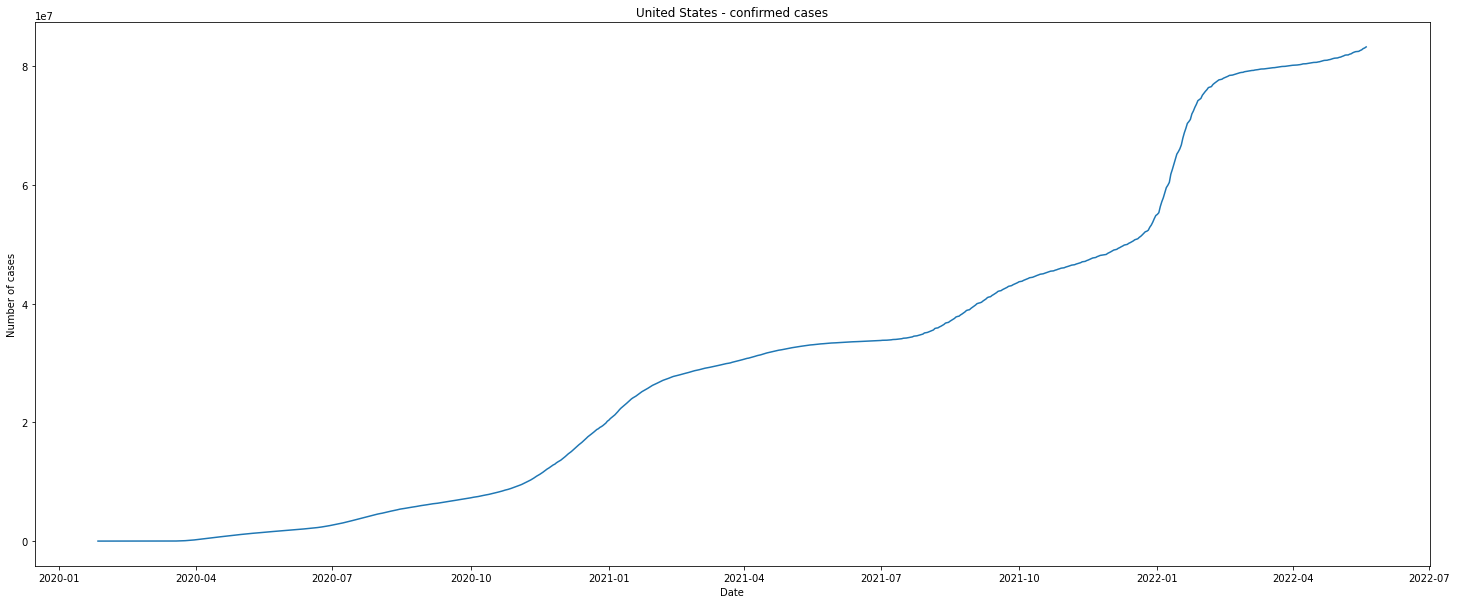

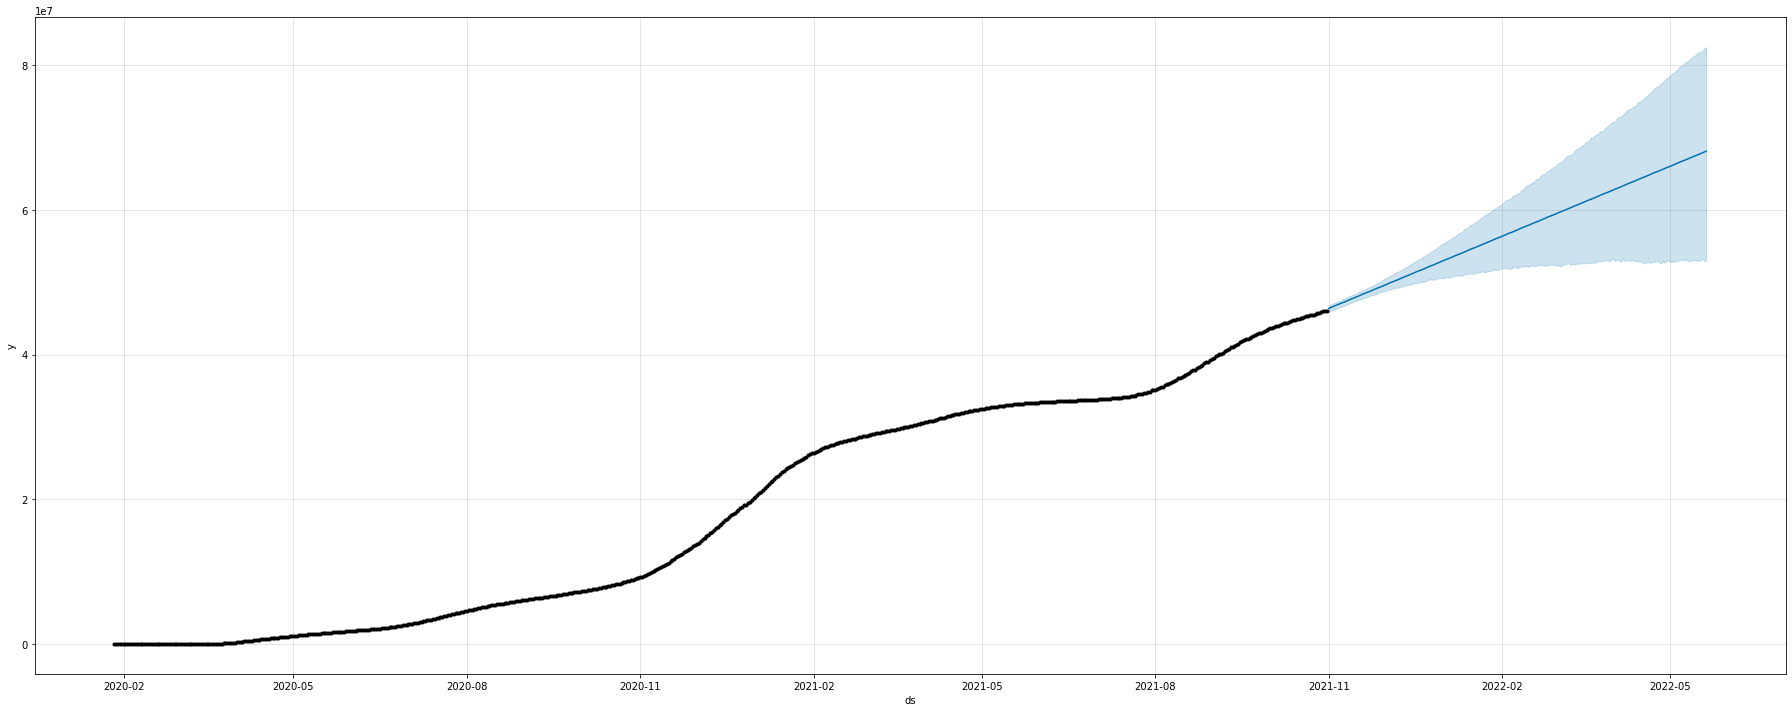

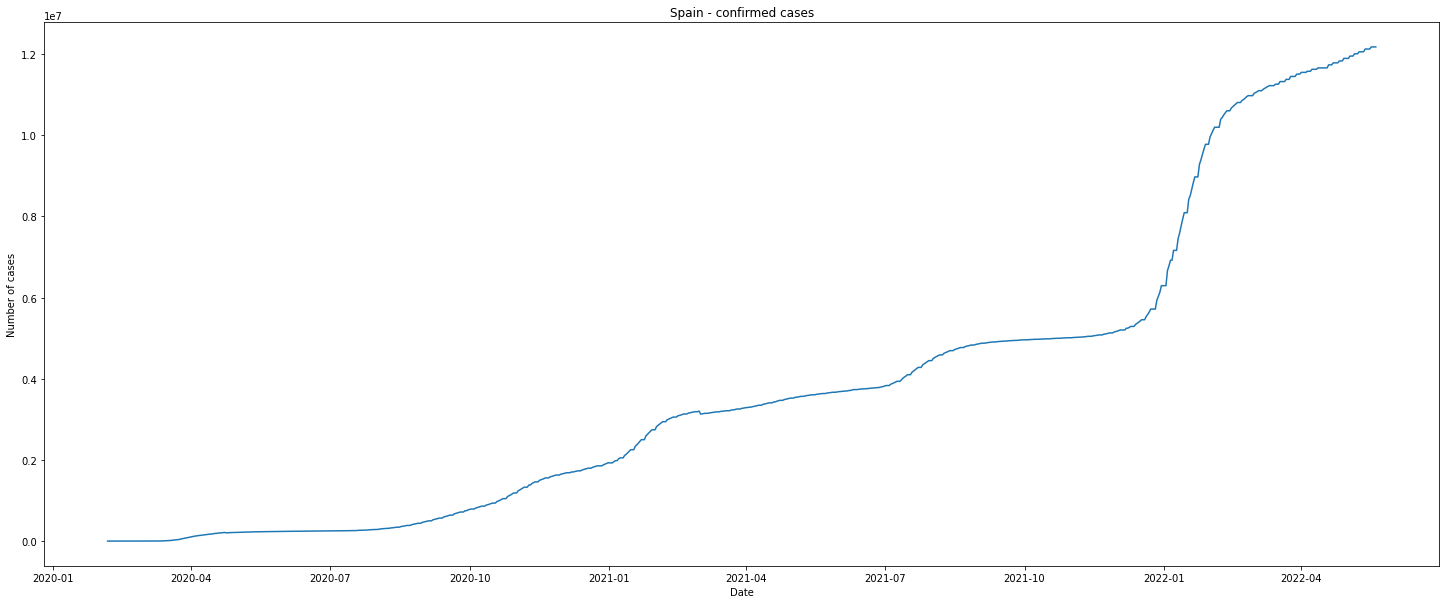

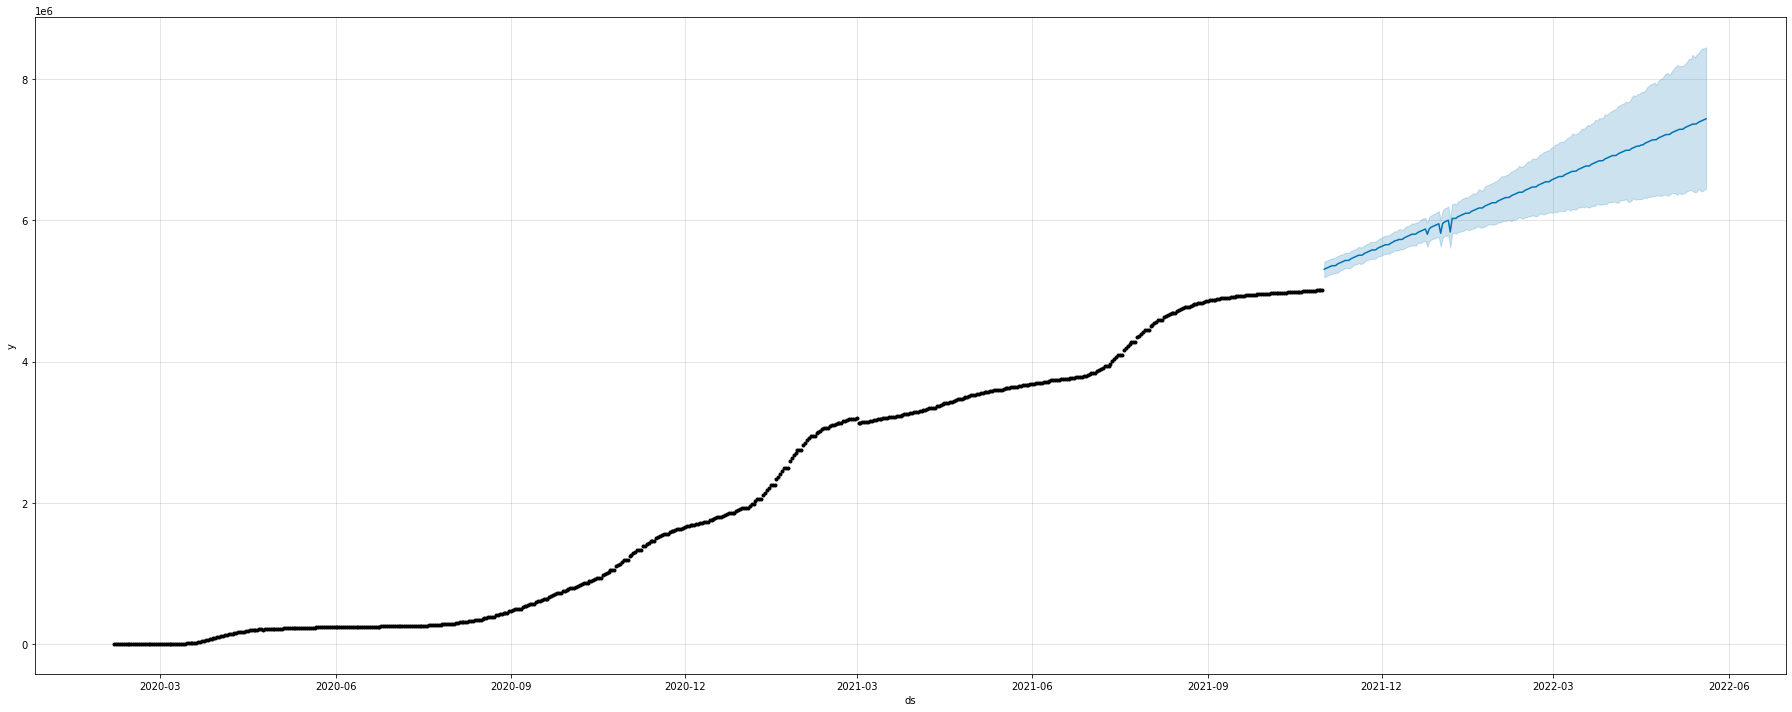

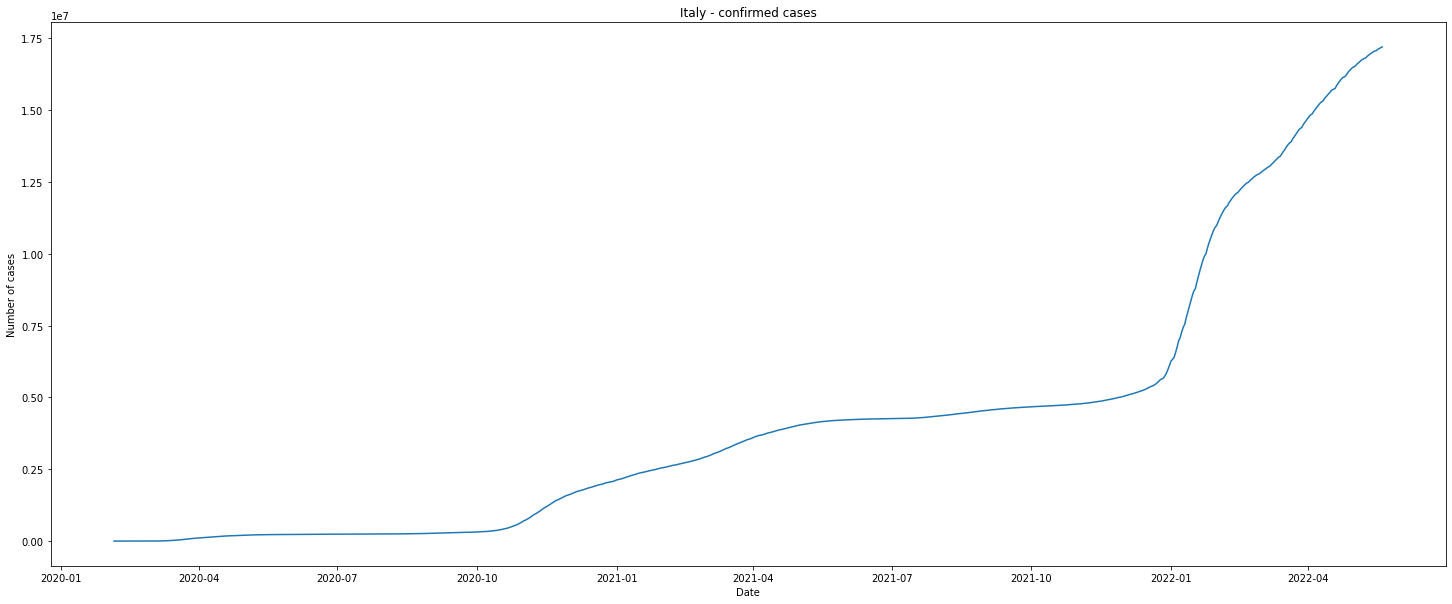

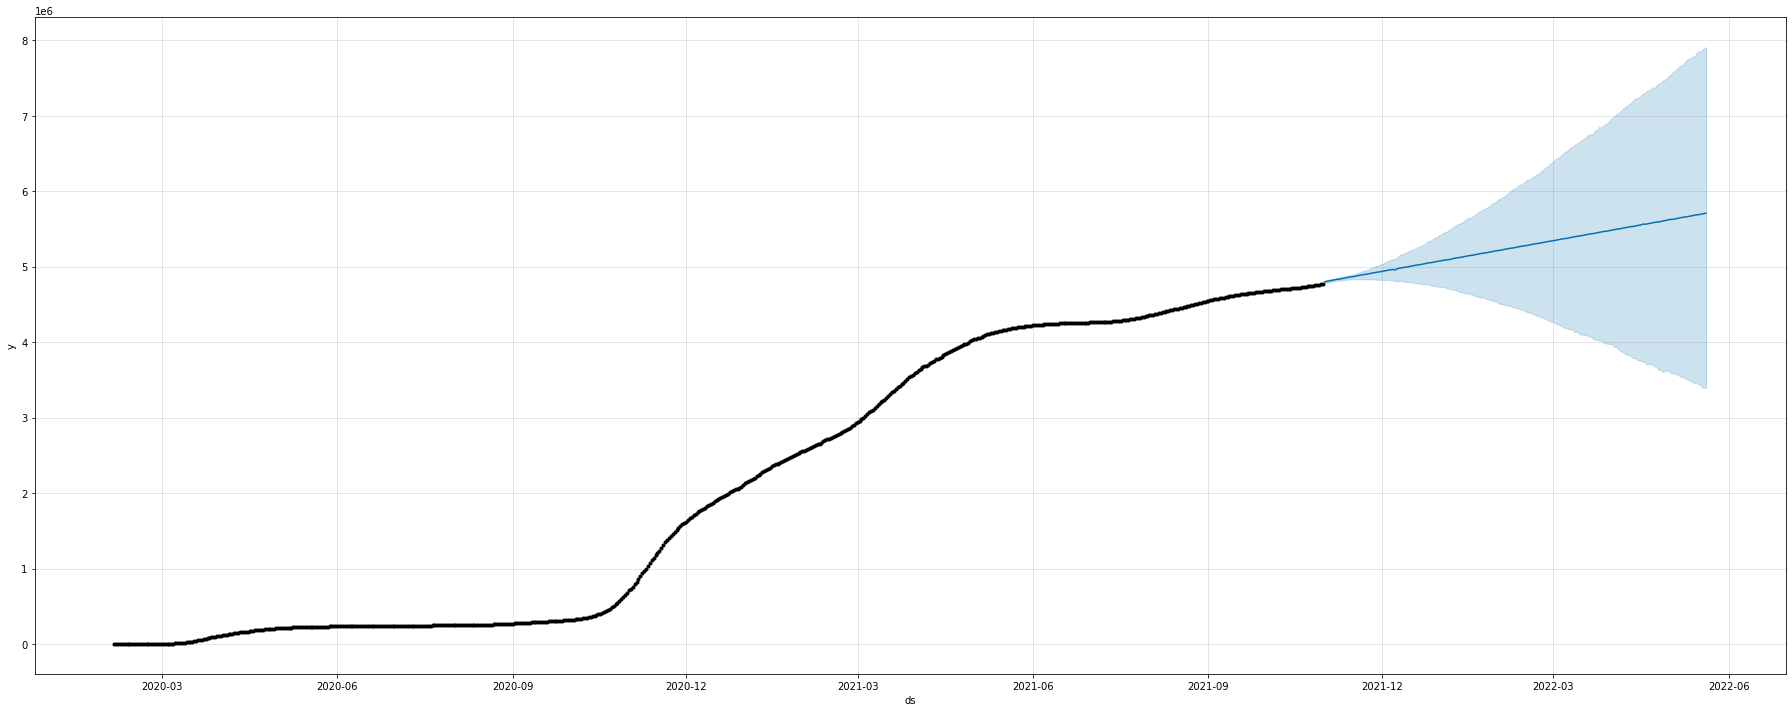

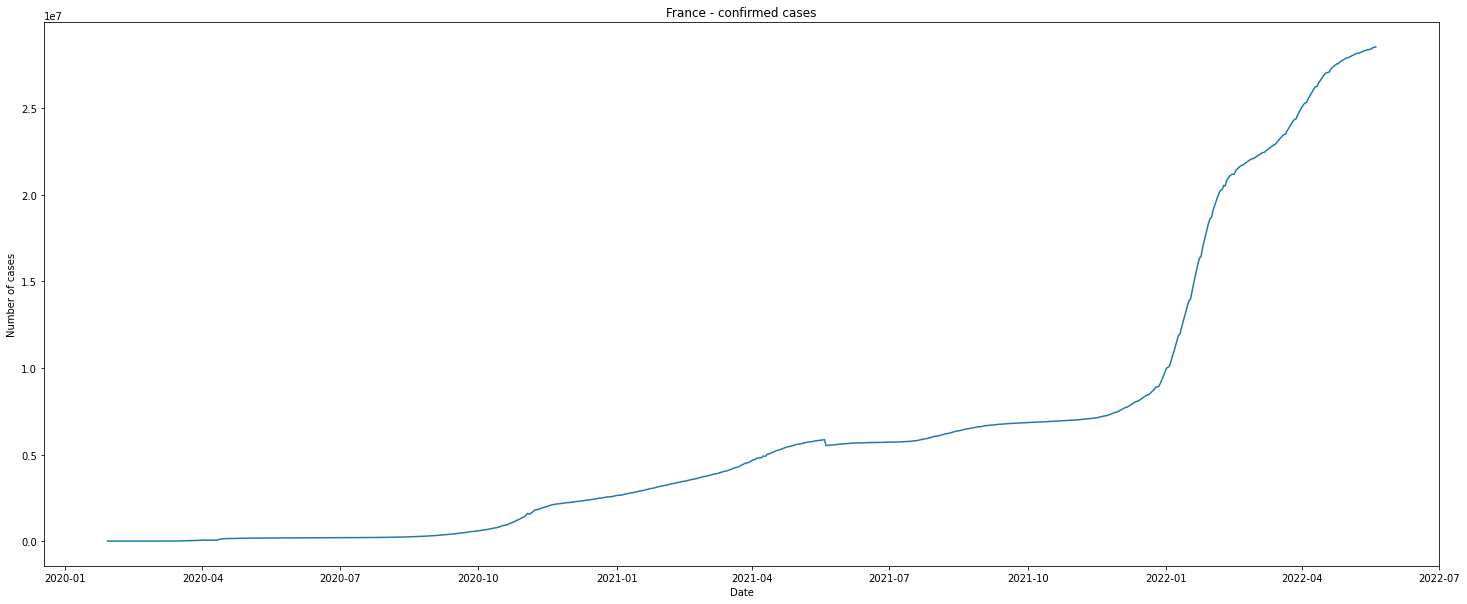

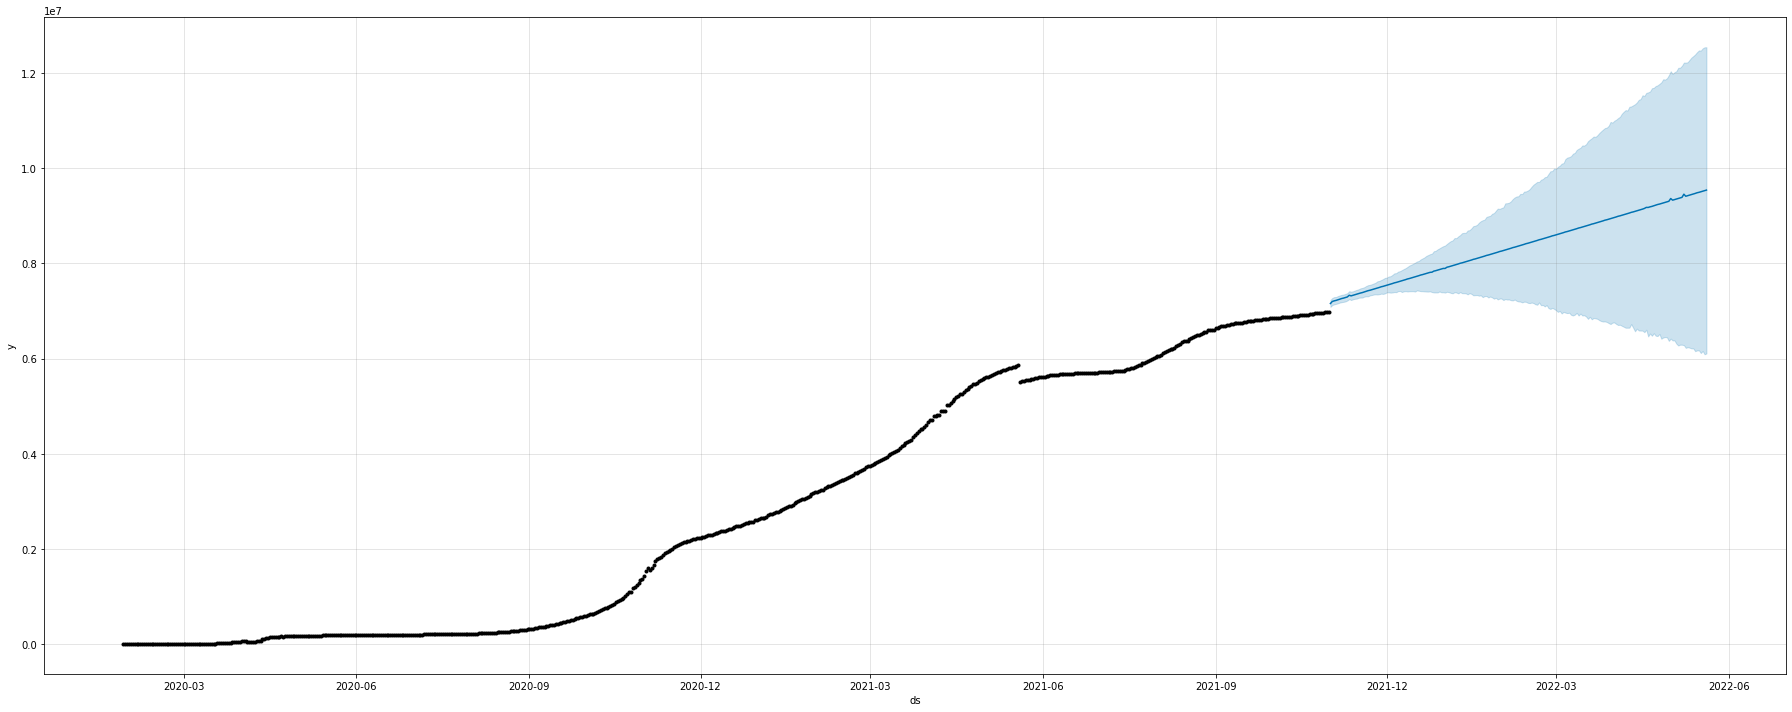

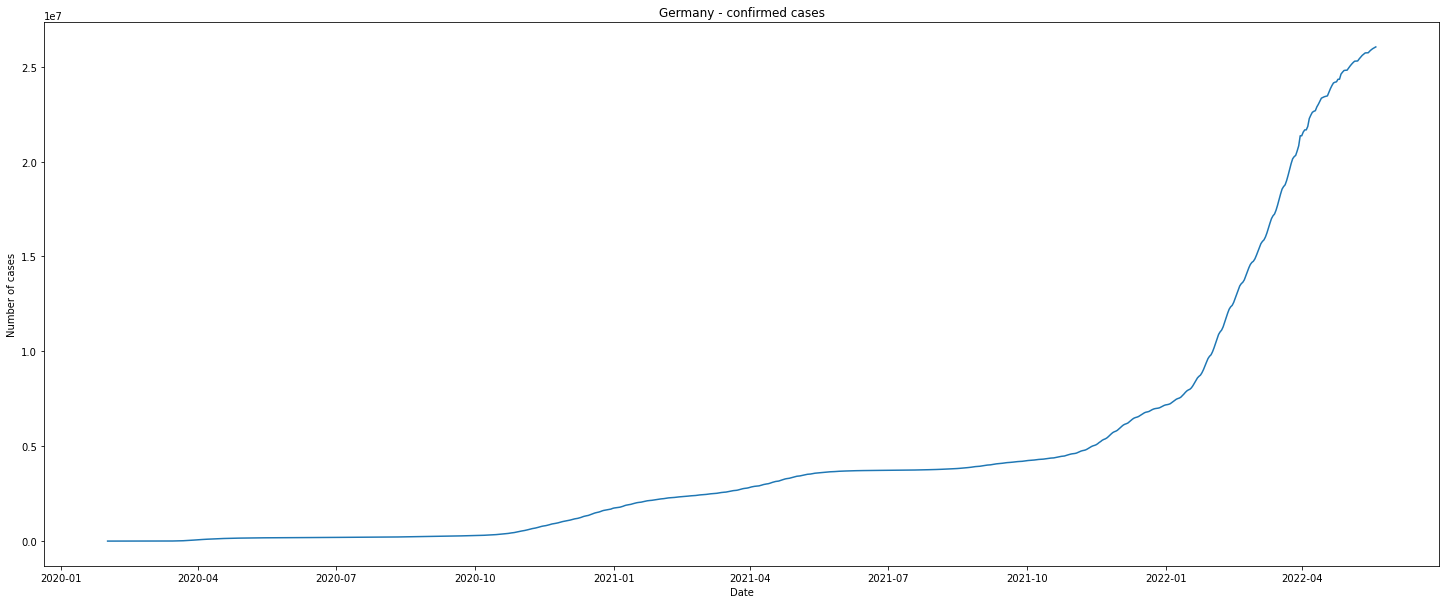

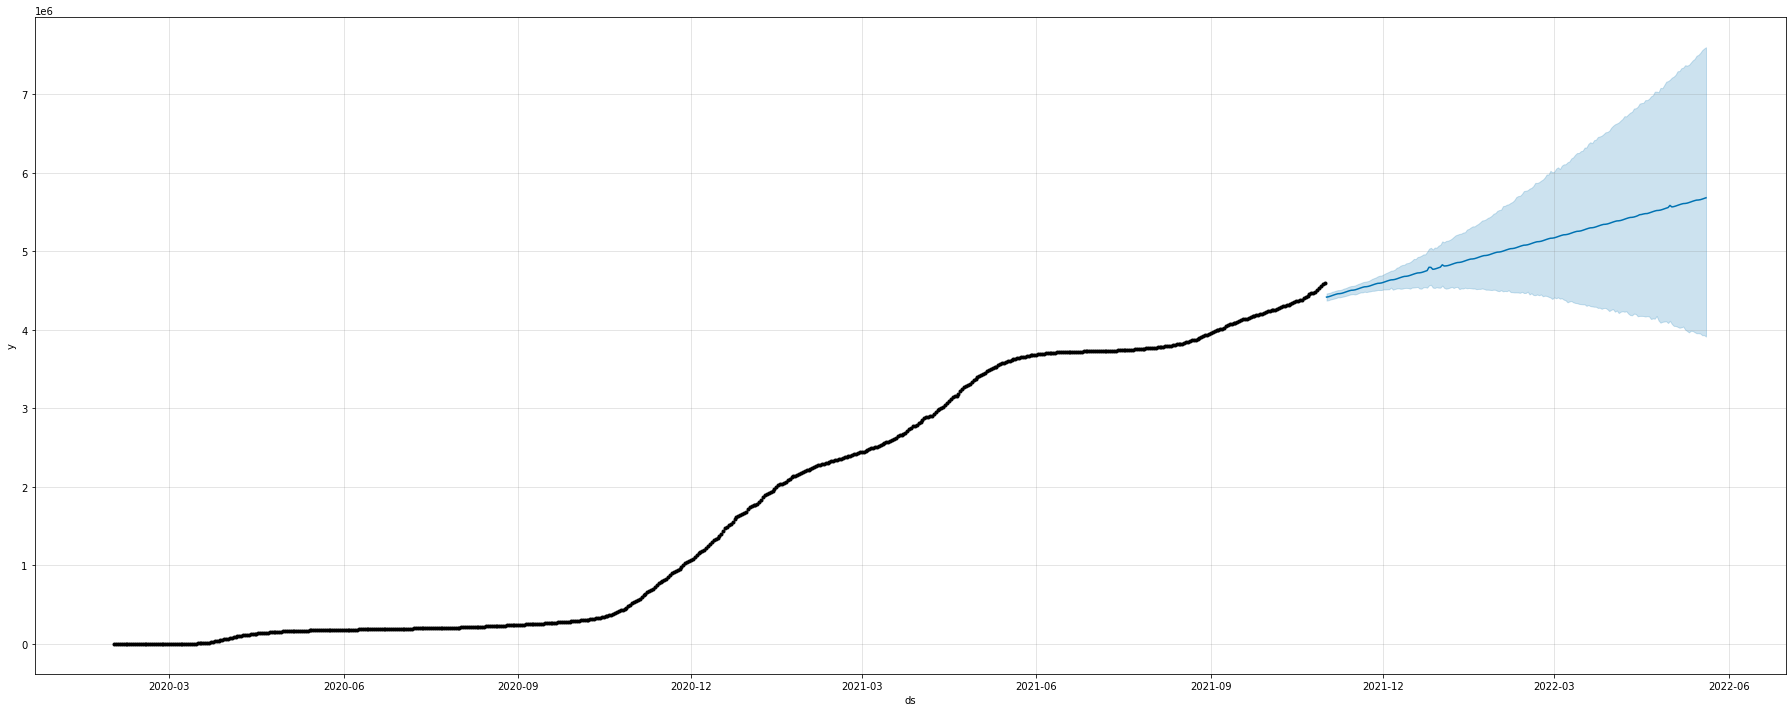

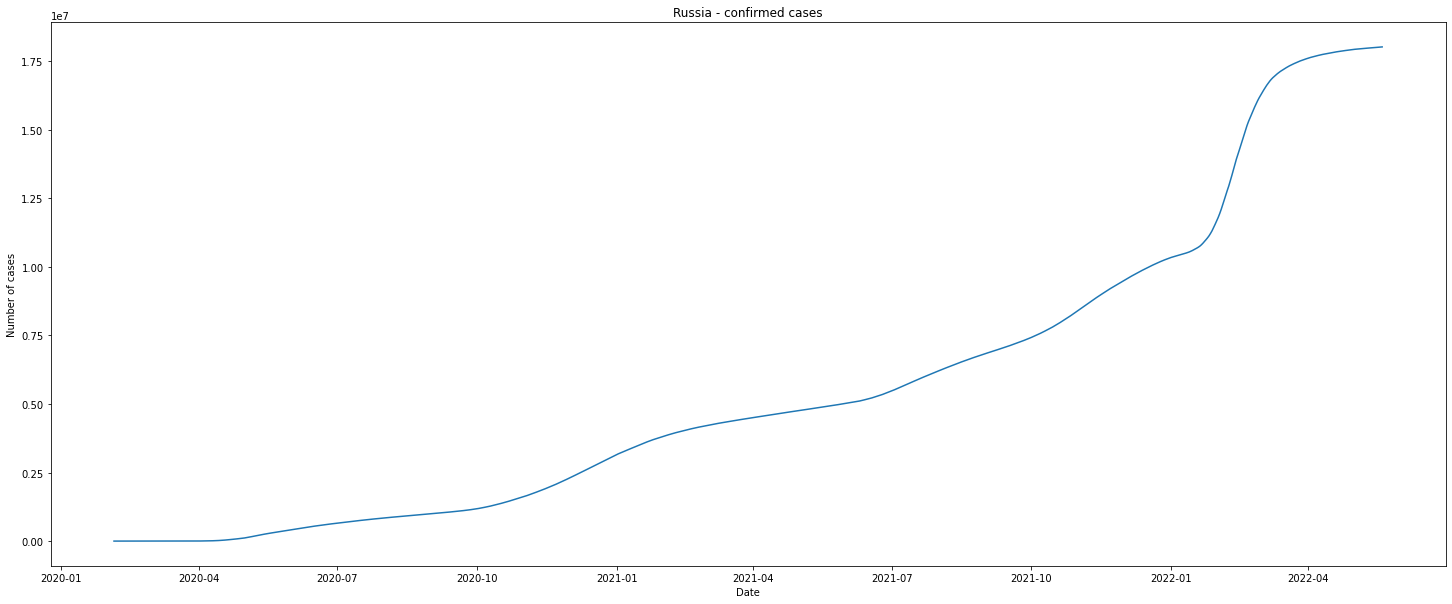

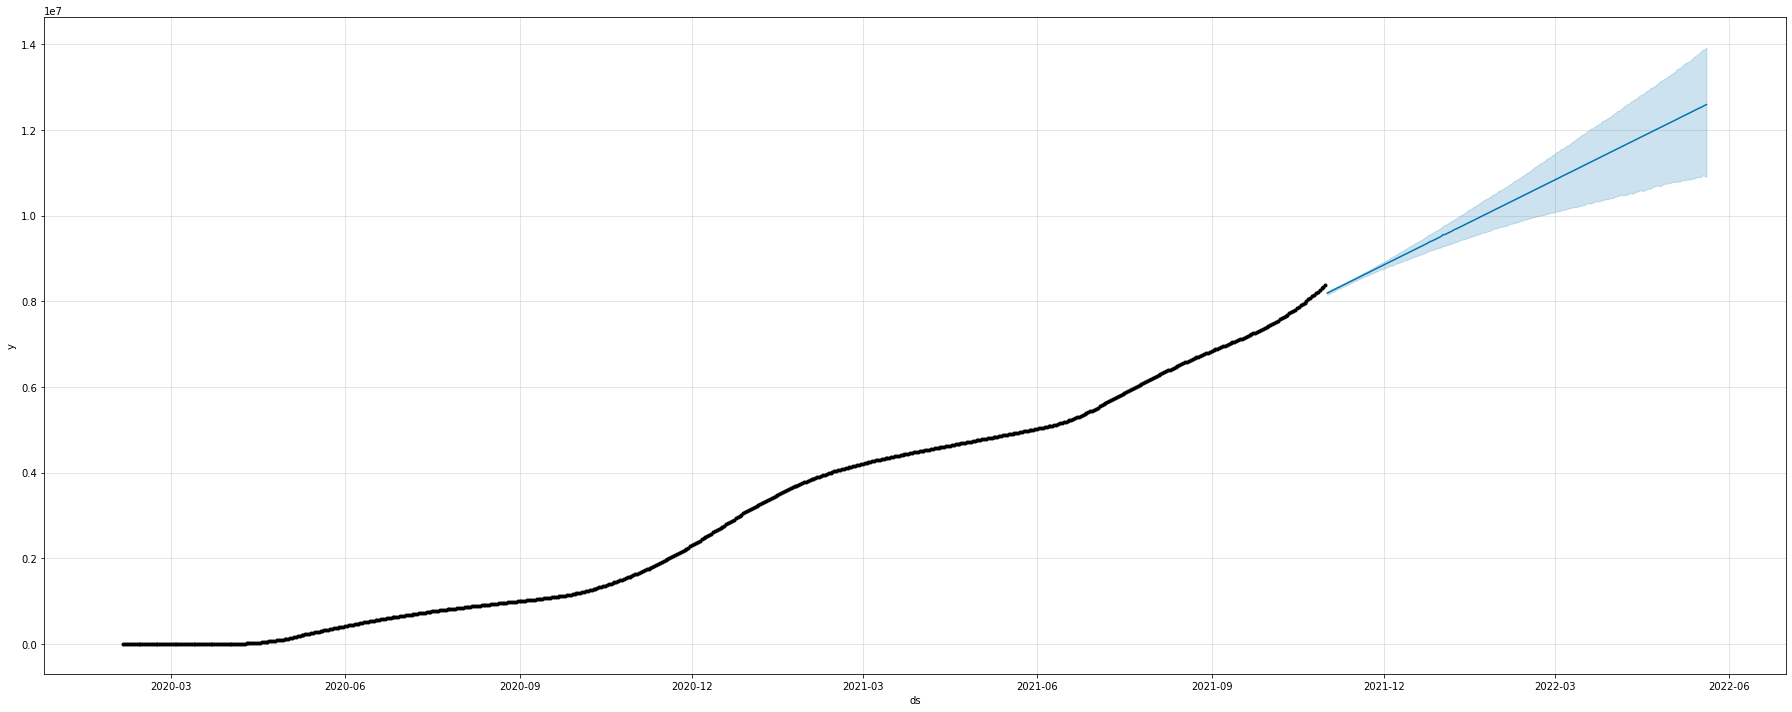

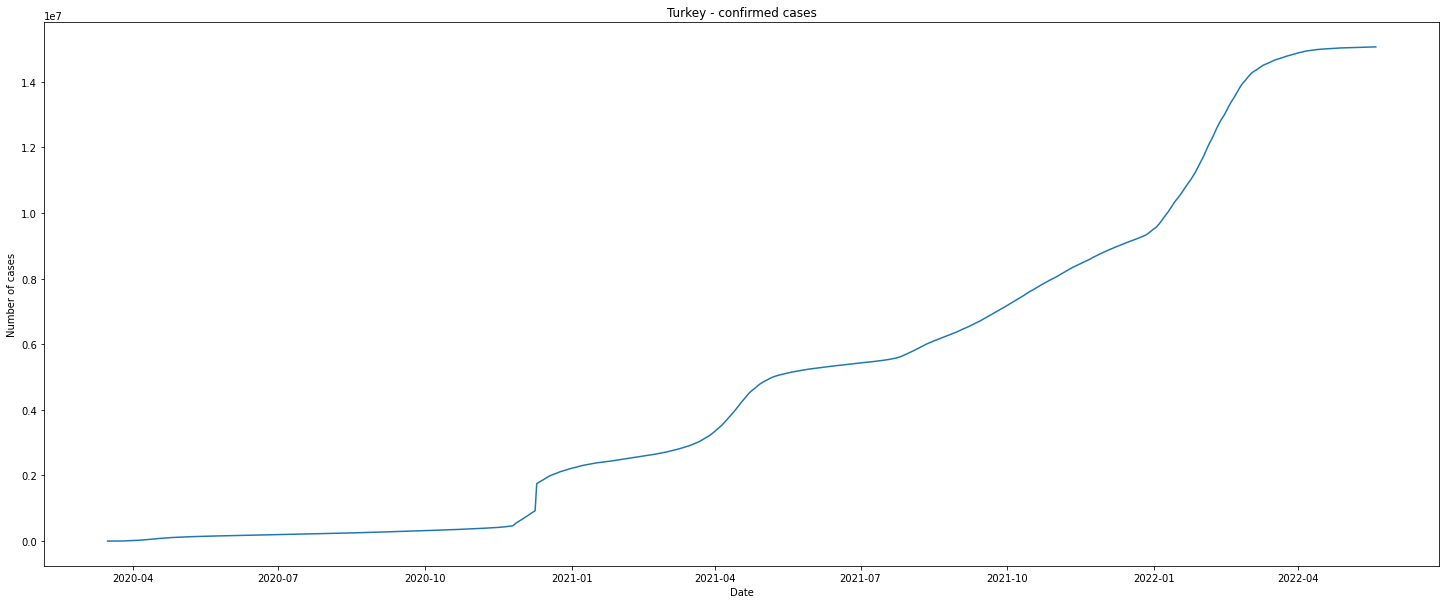

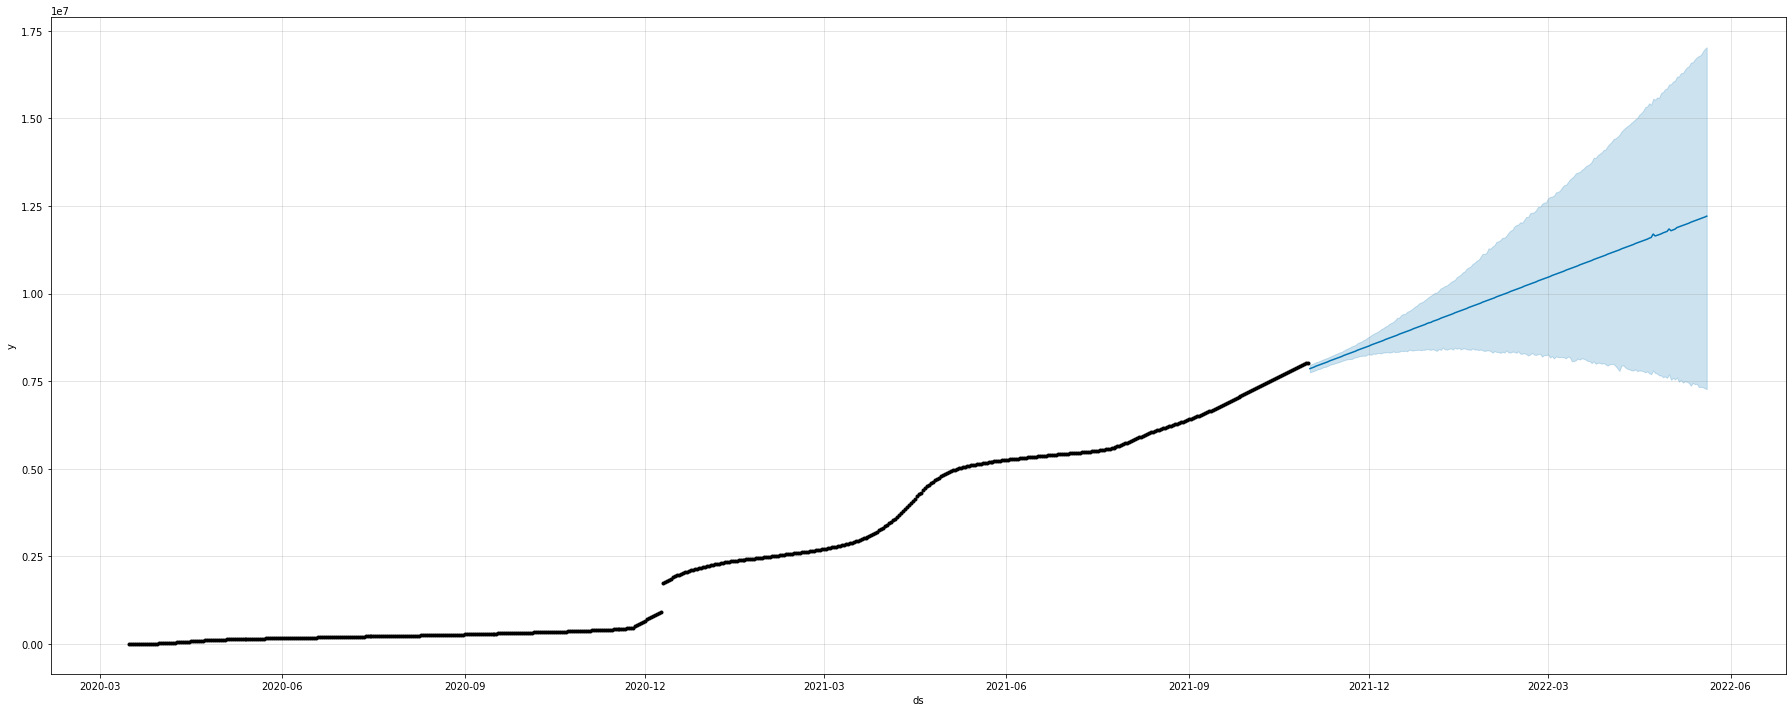

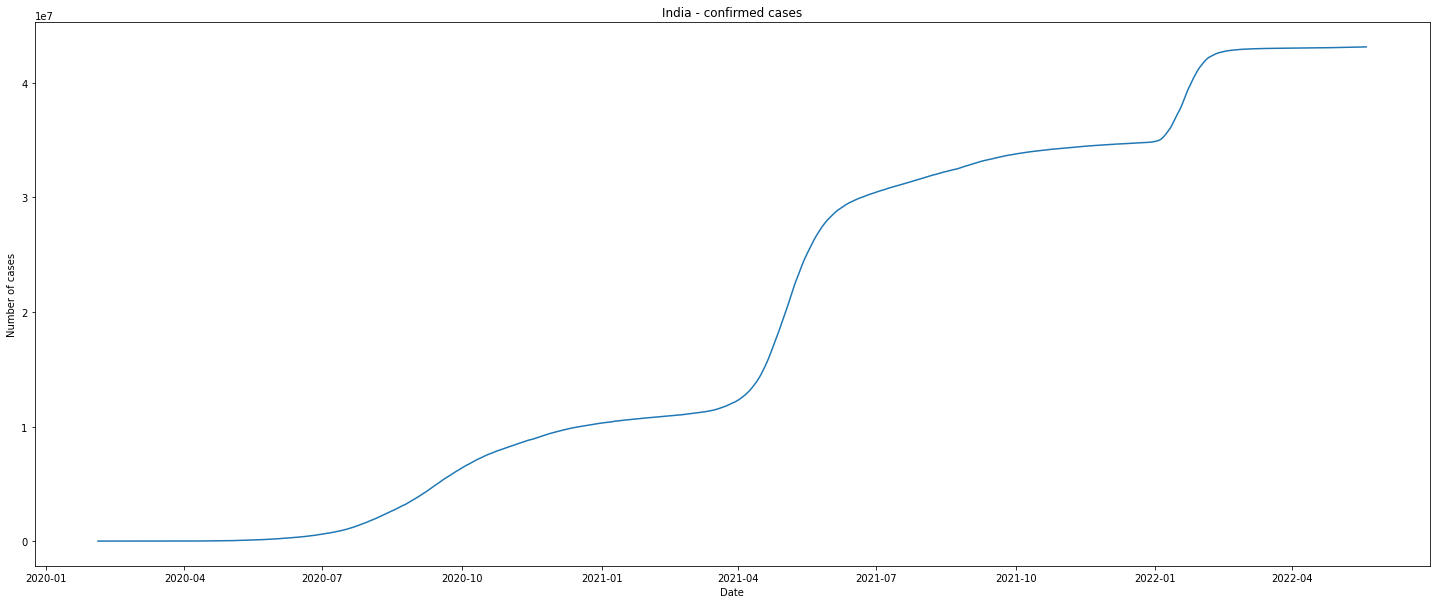

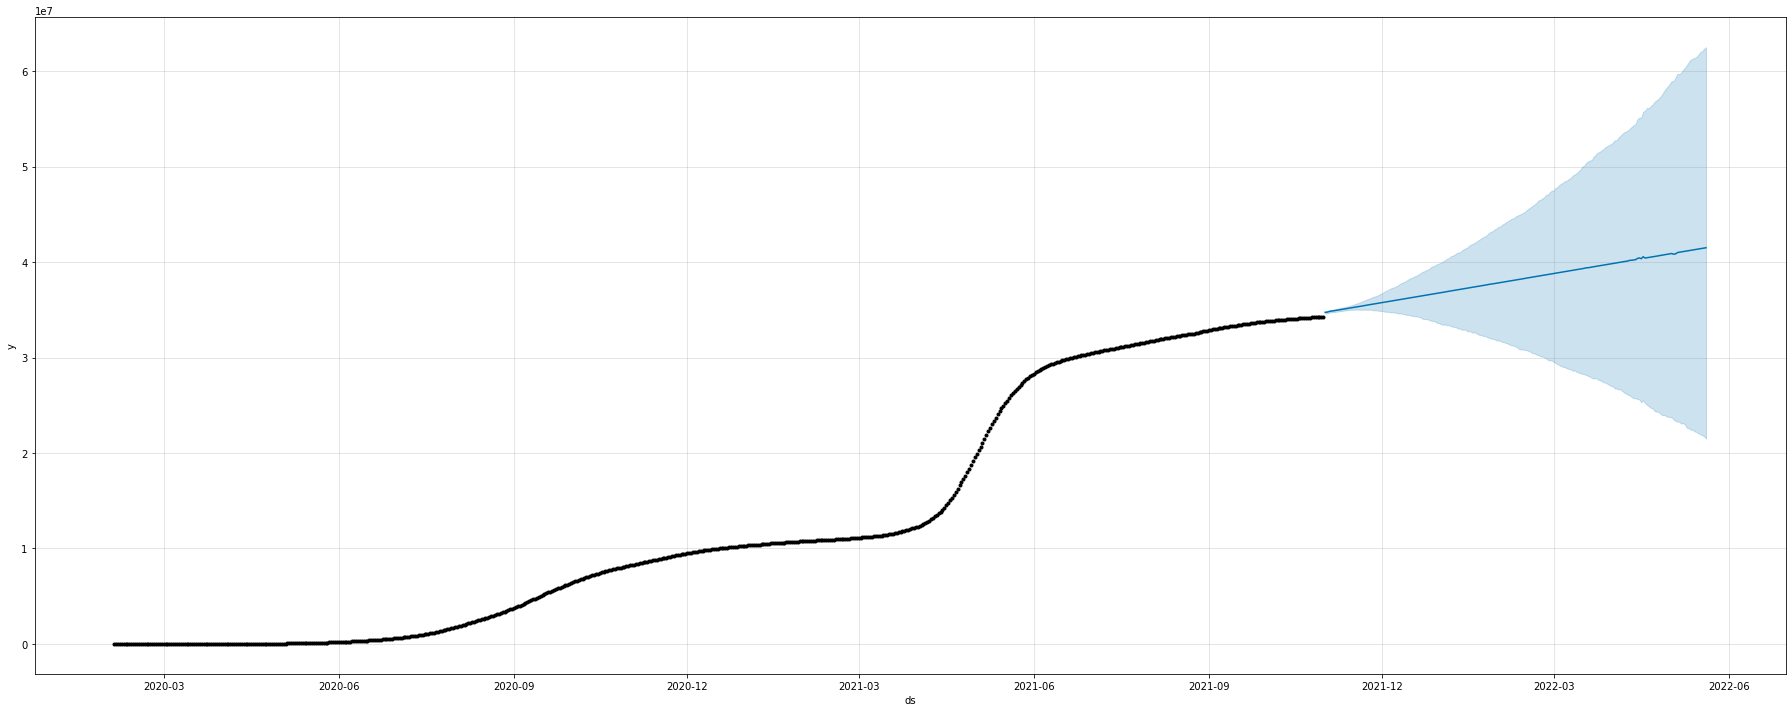

In [79]:
forecasting_results = pd.DataFrame(columns=["Country", "Model", "MAE", "RMSE", "RRSE", "MAPE"])

# US
us_start_date = "2020-01-27"
forecasting_results = fbprophet_forecasting(country_list[7], country_iso_code_list[7], data_type_list[0], us_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# ES
es_start_date = "2020-02-06"
forecasting_results = fbprophet_forecasting(country_list[1], country_iso_code_list[1], data_type_list[0], es_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# IT
it_start_date = "2020-02-05"
forecasting_results = fbprophet_forecasting(country_list[4], country_iso_code_list[4], data_type_list[0], it_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# FR
fr_start_date = "2020-01-29"
forecasting_results = fbprophet_forecasting(country_list[2], country_iso_code_list[2], data_type_list[0], fr_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# DE
de_start_date = "2020-02-01"
forecasting_results = fbprophet_forecasting(country_list[0], country_iso_code_list[0], data_type_list[0], de_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# RU
ru_start_date = "2020-02-05"
forecasting_results = fbprophet_forecasting(country_list[5], country_iso_code_list[5], data_type_list[0], ru_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# TR
tr_start_date = "2020-03-16"
forecasting_results = fbprophet_forecasting(country_list[6], country_iso_code_list[6], data_type_list[0], tr_start_date, "2020-05-20", "2020-05-01", forecasting_results)

# IN
in_start_date = "2020-02-04"
forecasting_results = fbprophet_forecasting(country_list[3], country_iso_code_list[3], data_type_list[0], in_start_date, "2020-05-20", "2020-05-01", forecasting_results)

In [74]:
forecasting_results.to_csv('/home/vladimir/GoogleDrive/Courses/03Third_semester/projects/dsa-project/data/performance_forecasting_results_confirmed_cases_fbprophet.csv', index=False)

,Country,Model,MAE,RMSE,RRSE,MAPE
0,United States,Facebook Prophet,11525977.139,13976920.468,1.09,14.976
1,Spain,Facebook Prophet,2881603.876,3455010.025,1.26,27.399
2,Italy,Facebook Prophet,5440793.207,6848271.454,1.258,40.483
3,France,Facebook Prophet,9533153.283,11946923.6,1.258,42.119
4,Germany,Facebook Prophet,8503195.472,11051297.287,1.298,50.451
5,Russia,Facebook Prophet,3182278.717,4012110.987,1.17,20.096
6,Turkey,Facebook Prophet,2040313.12,2519468.326,1.05,14.883
7,India,Facebook Prophet,2370796.951,2677347.812,1.095,5.799


# Forecasting using Neural Prophet

In [62]:
def nprophet_forecasting(country, country_code, data_type, start_date, end_date, split_date, results_table):
    df = pd.read_csv("data/data20_q1/" + country_code + "_" + data_type + ".csv")
    df["ds"] = pd.to_datetime(df["ds"])
    # print(df.info())

    period = (df['ds'] >= start_date) & (df['ds'] <= end_date)
    df = df.loc[period]

    # Fit Neural Prophet model
    train = df.loc[df["ds"] < split_date]
    test = df.loc[df["ds"] >= split_date]
    # print("Train size = %d, test size = %d" % (len(train), len(test)))

    model = NeuralProphet()
    if (country == "United States"):
        ;
    else:
        model.add_country_holidays(country_name=country)
    model.fit(train)
    forecast = model.predict(test)
    fig = model.plot(forecast, figsize=(25, 10))
    fig.savefig("/home/vladimir/GoogleDrive/Courses/03Third_semester/projects/dsa-project/data/images/" + country.lower() + "_" + data_type + "_neuralprophet_forecast.png")
    # print(fig)

    MAE = mean_absolute_error(y_true=test["y"], y_pred=forecast["yhat1"])
    RMSE = math.sqrt(mean_squared_error(y_true=test["y"], y_pred=forecast["yhat1"]))
    # RRSE = rrse(y_true=test["y"], y_pred=forecast["yhat1"])
    RRSE = root_relative_squared_error(np.array(test["y"]), np.array(forecast["yhat1"]))
    MAPE = mean_absolute_percentage_error(y_true=test["y"], y_pred=forecast["yhat1"]) * 100
    # print(country.upper() + " | " + data_type)
    # print("MAE:", MAE)
    # print("RMSE:", RMSE)
    # print("RRSE:", RRSE)
    # print("MAPE", MAPE, "%")

    res = pd.DataFrame({"Country" : country, "Model"  : "Neural Prophet", "MAE"  : round(MAE, 3), "RMSE" : round(RMSE, 3), "RRSE" : round(RRSE, 3), "MAPE" : round(MAPE, 3)}, index=[len(results_table)])
    results_table = pd.concat([results_table, res])
    return results_table

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.845% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.845% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:NP.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override thi

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-01, min: 1.88E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.35E-01, min: 1.88E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.00E-01, min: 9.44E-01
INFO:NP.utils_torch:lr-range-test results: steep: 2.00E-01, min: 9.44E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.88E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.88E-01
Epoch[225/225]: 100%|██████████| 225/225 [00:12<00:00, 18.60it/s, SmoothL1Loss=2.45e-5, MAE=2.05e+5, RMSE=2.94e+5, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.19E-01, min: 2.24E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.19E-01, min: 2.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.12E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.12E-01
Epoch[226/226]: 100%|██████████| 226/226 [00:12<00:00, 17.44it/s, SmoothL1Loss=0.000181, MAE=6.78e+4, RMSE=9.22e+4, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.88E+00, min: 2.66E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.88E+00, min: 2.66E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-01, min: 1.88E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.35E-01, min: 1.88E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.98E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 3.98E-01
Epoch[226/226]: 100%|██████████| 226/226 [00:13<00:00, 17.33it/s, SmoothL1Loss=2.07e-5, MAE=2.3e+4, RMSE=2.96e+4, RegLoss=0]  
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.68E-01, min: 6.31E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.68E-01, min: 6.31E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.68E-01, min: 1.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 1.68E-01, min: 1.33E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.41E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 1.41E-01
Epoch[225/225]: 100%|██████████| 225/225 [00:13<00:00, 17.09it/s, SmoothL1Loss=8.86e-5, MAE=6.72e+4, RMSE=8.91e+4, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-01, min: 1.33E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.35E-01, min: 1.33E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.82E-01, min: 1.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.82E-01, min: 1.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.11E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.11E-01
Epoch[225/225]: 100%|██████████| 225/225 [00:12<00:00, 17.39it/s, SmoothL1Loss=3.48e-5, MAE=2.47e+4, RMSE=3.41e+4, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.35E-01, min: 3.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 3.35E-01, min: 3.76E+00


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.82E-01, min: 1.12E+00
INFO:NP.utils_torch:lr-range-test results: steep: 2.82E-01, min: 1.12E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.11E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.11E-01
Epoch[226/226]: 100%|██████████| 226/226 [00:12<00:00, 17.47it/s, SmoothL1Loss=1.43e-5, MAE=3.03e+4, RMSE=3.88e+4, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.41E-02, min: 6.68E-01
INFO:NP.utils_torch:lr-range-test results: steep: 8.41E-02, min: 6.68E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.08E-02, min: 2.24E+00
INFO:NP.utils_torch:lr-range-test results: steep: 7.08E-02, min: 2.24E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.41E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.41E-02
Epoch[231/231]: 100%|██████████| 231/231 [00:12<00:00, 18.46it/s, SmoothL1Loss=0.00013, MAE=7.51e+4, RMSE=1.13e+5, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.12E+00, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.12E+00, min: 1.00E-01


  0%|          | 0/121 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.33E+00, min: 1.00E-01
INFO:NP.utils_torch:lr-range-test results: steep: 1.33E+00, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.31E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 5.31E-01
Epoch[225/225]: 100%|██████████| 225/225 [00:13<00:00, 17.08it/s, SmoothL1Loss=0.000105, MAE=2.63e+5, RMSE=4.5e+5, RegLoss=0] 
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is 

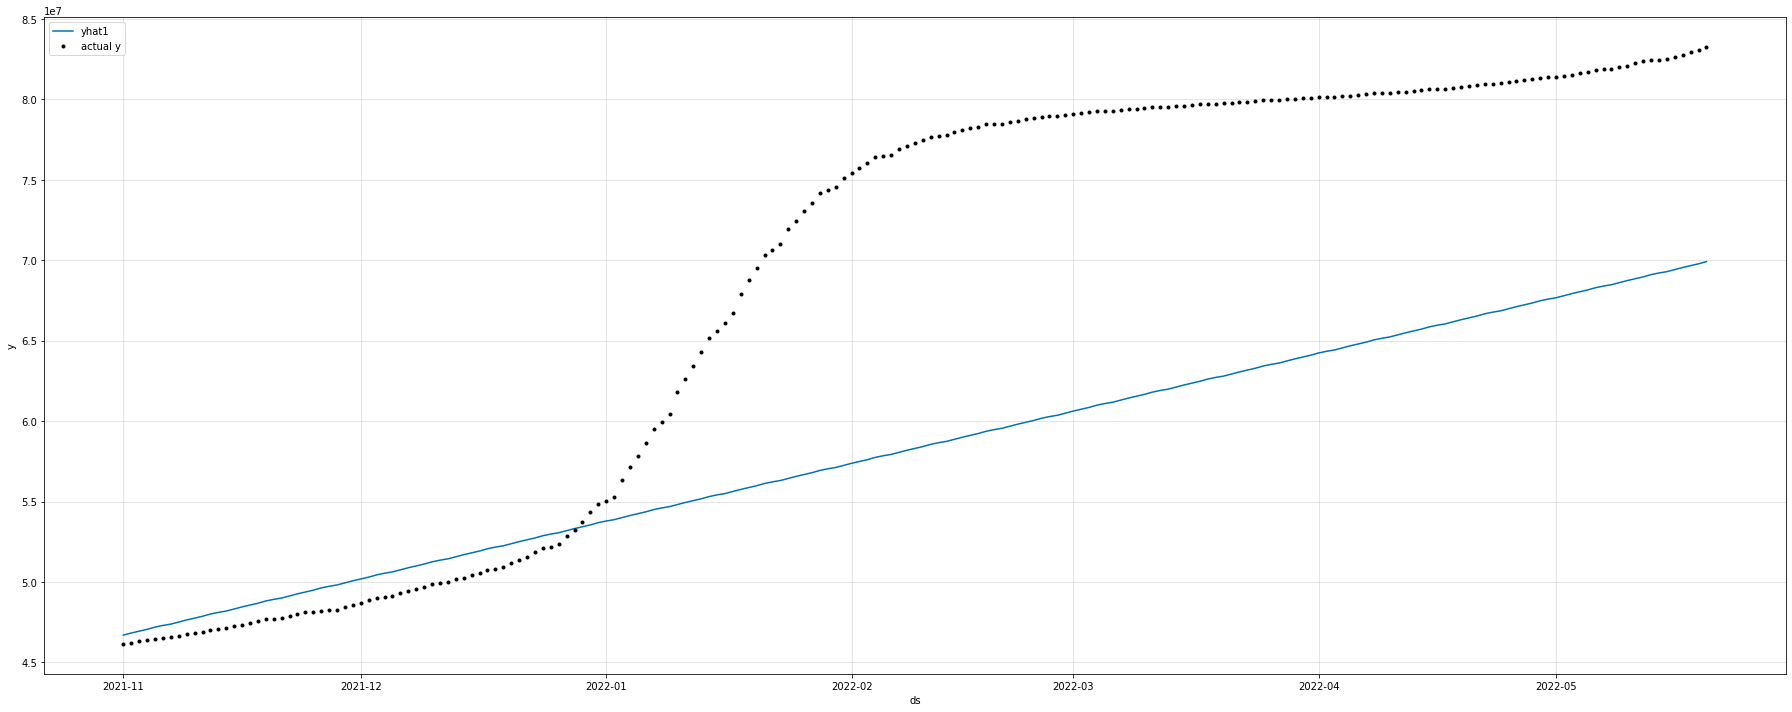

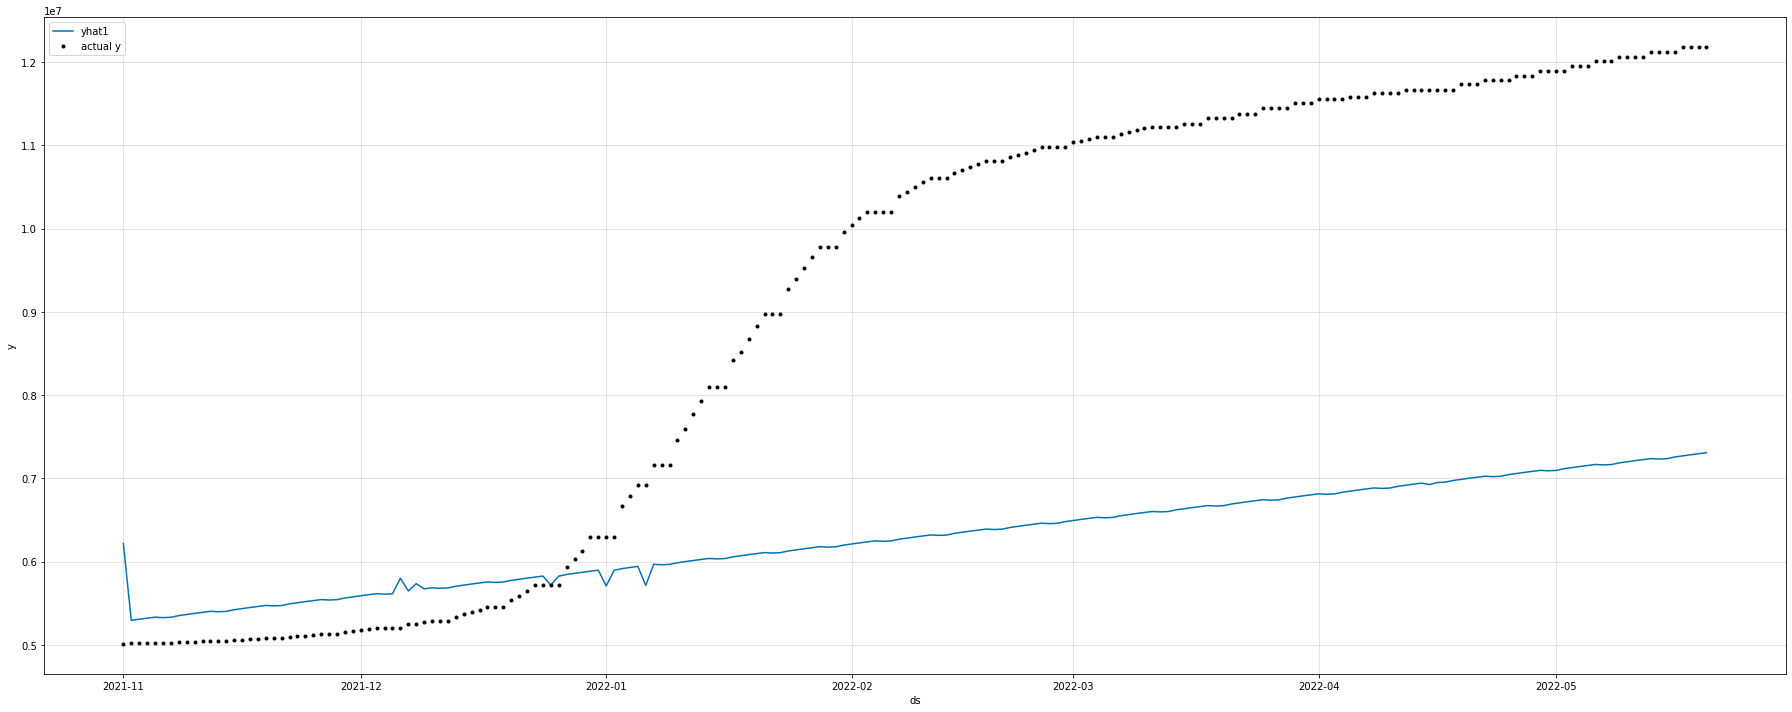

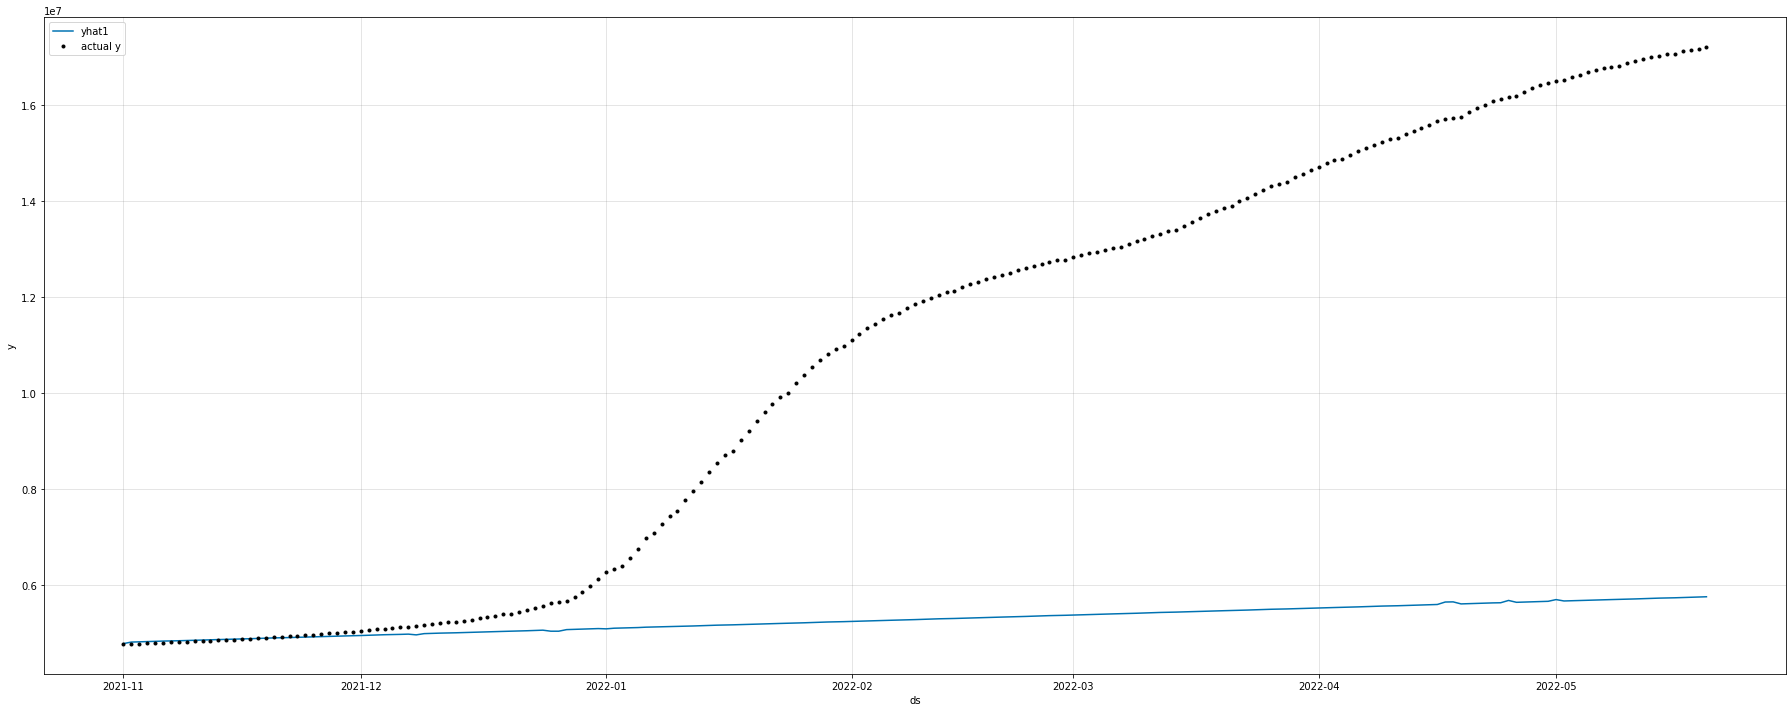

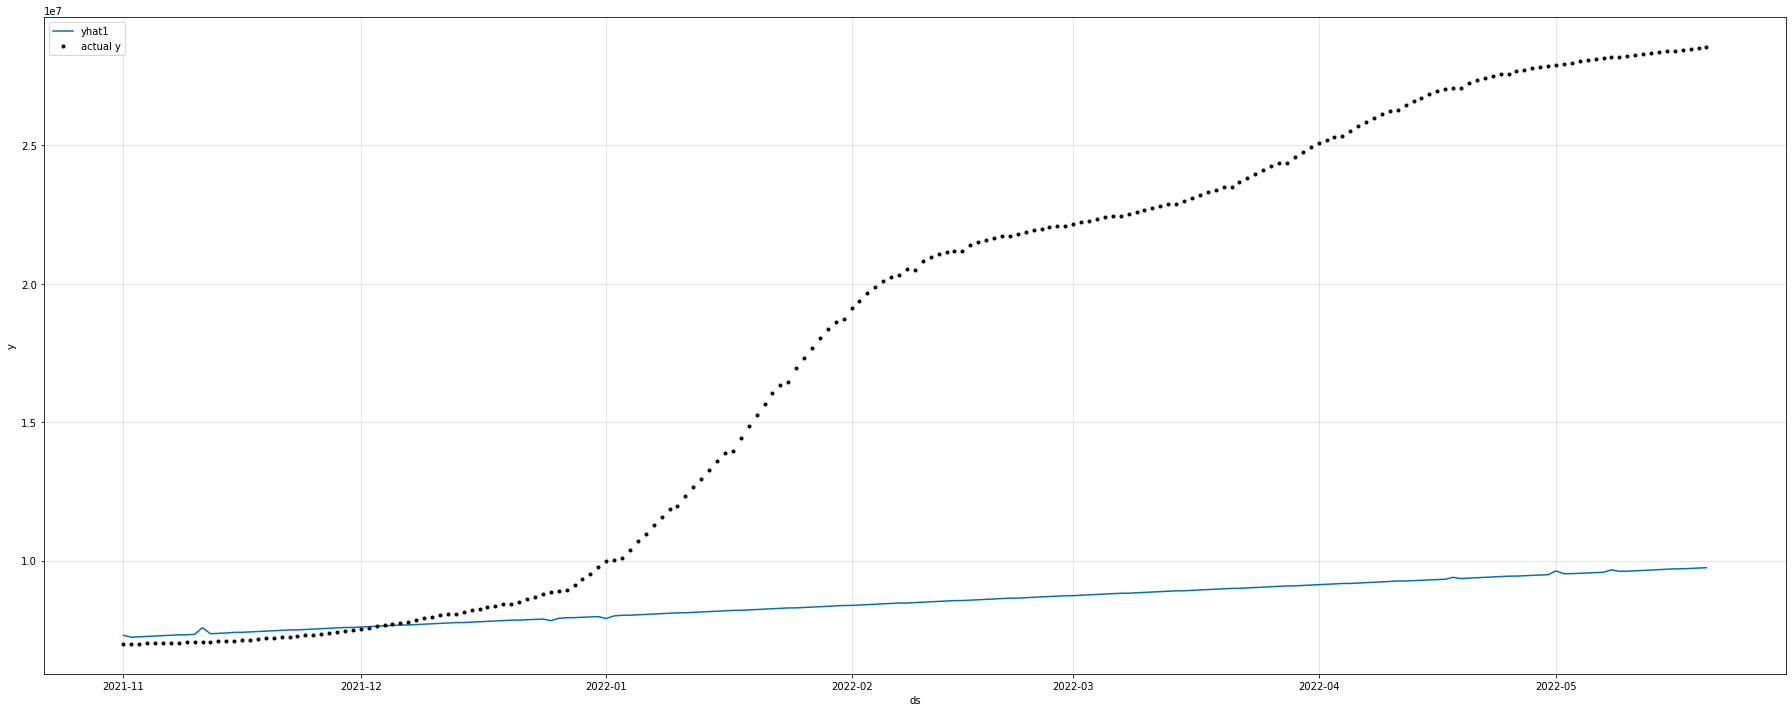

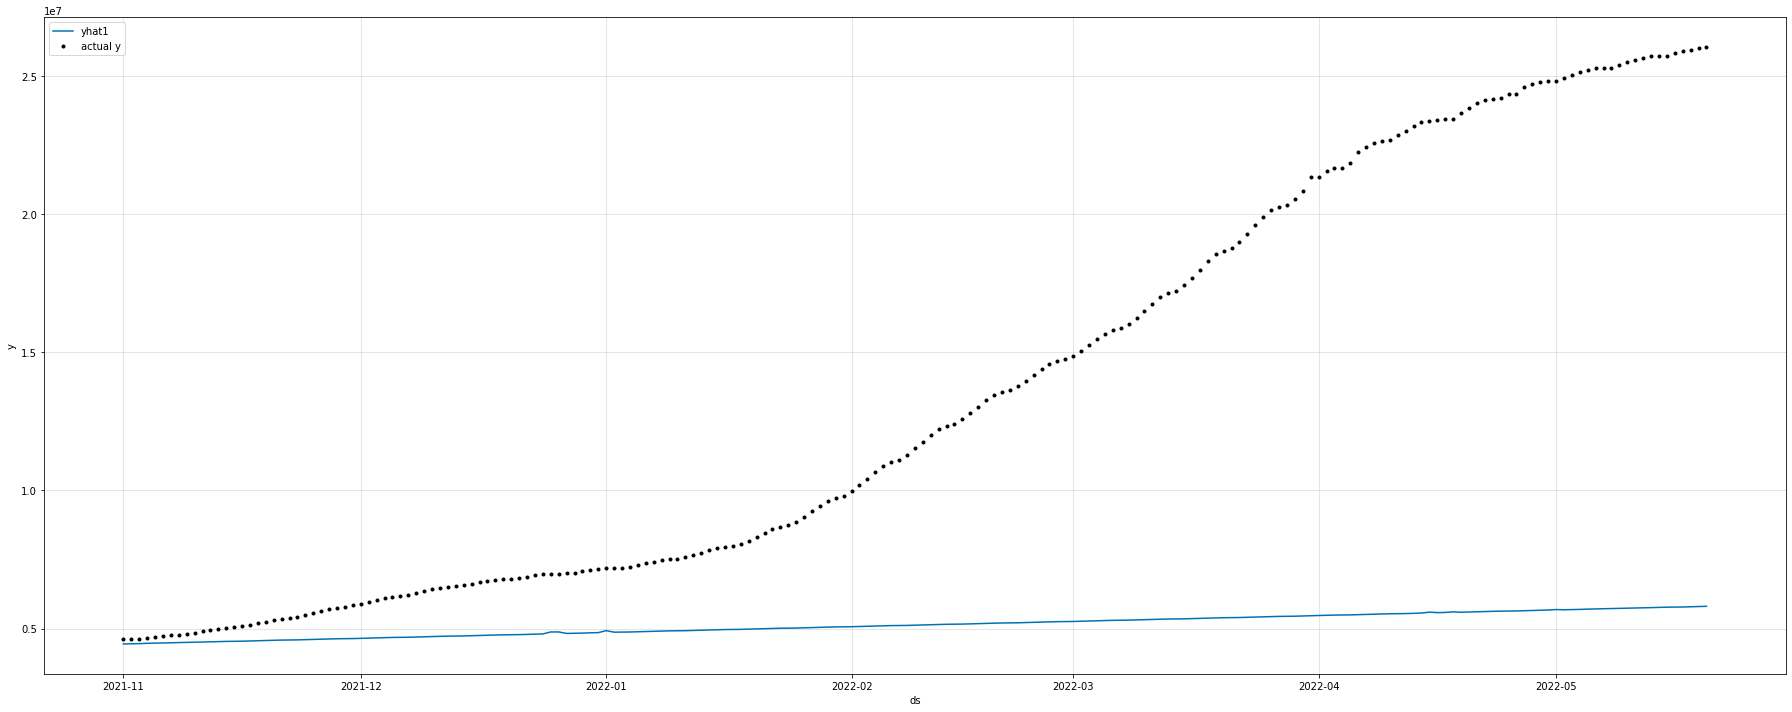

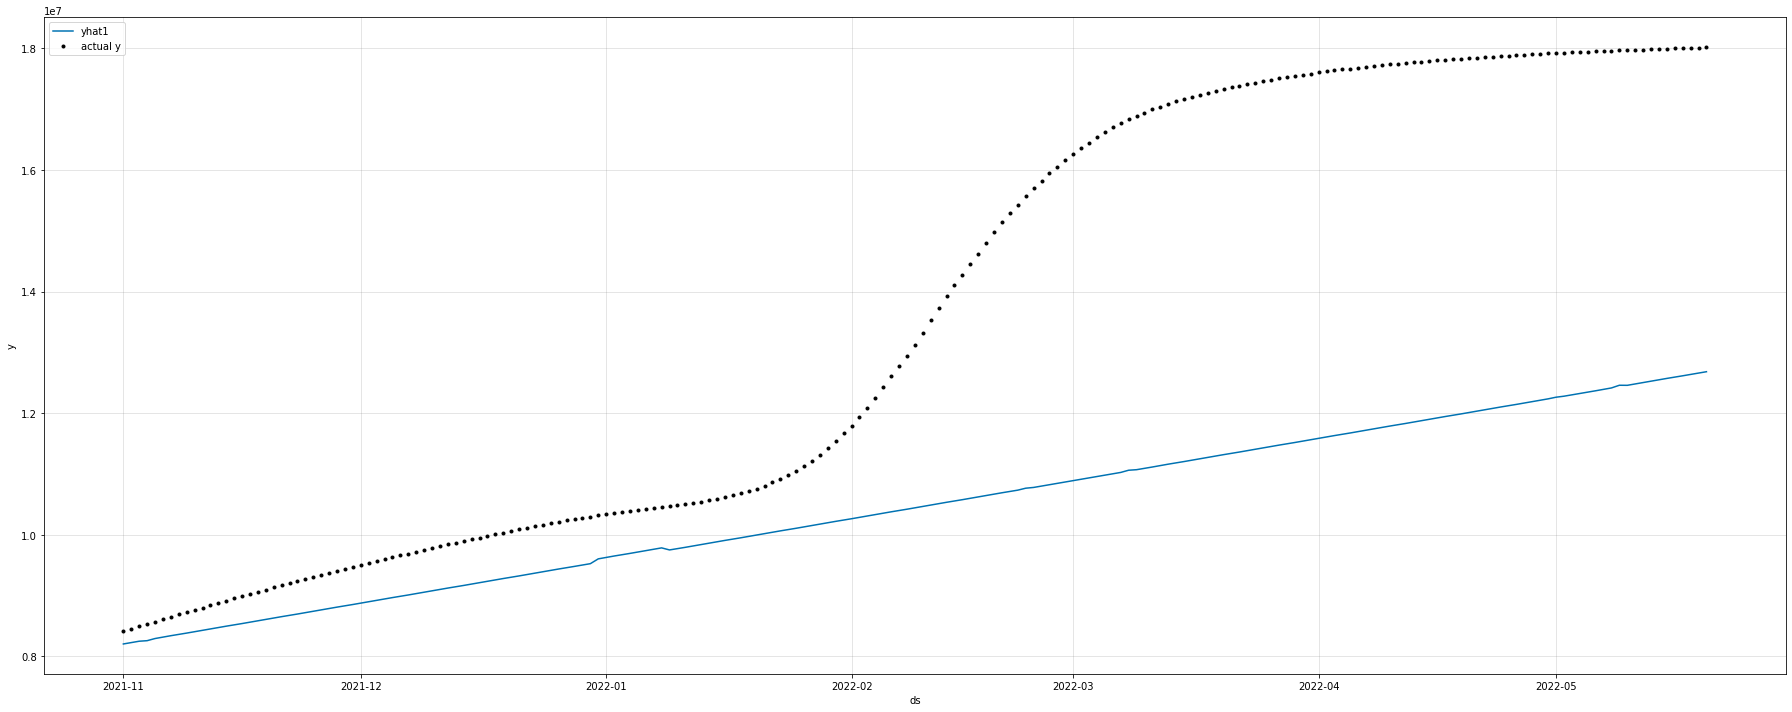

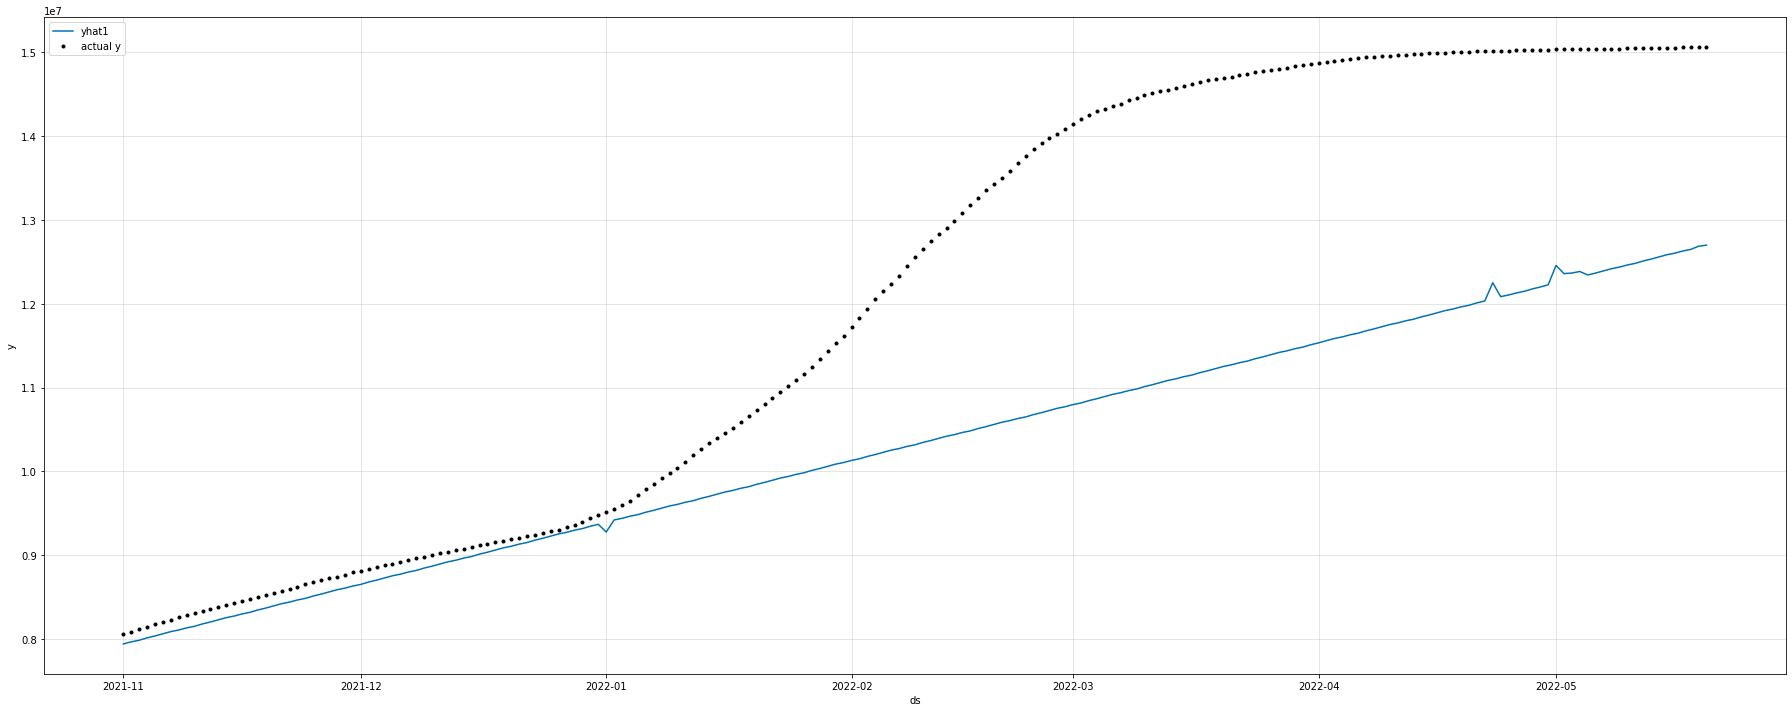

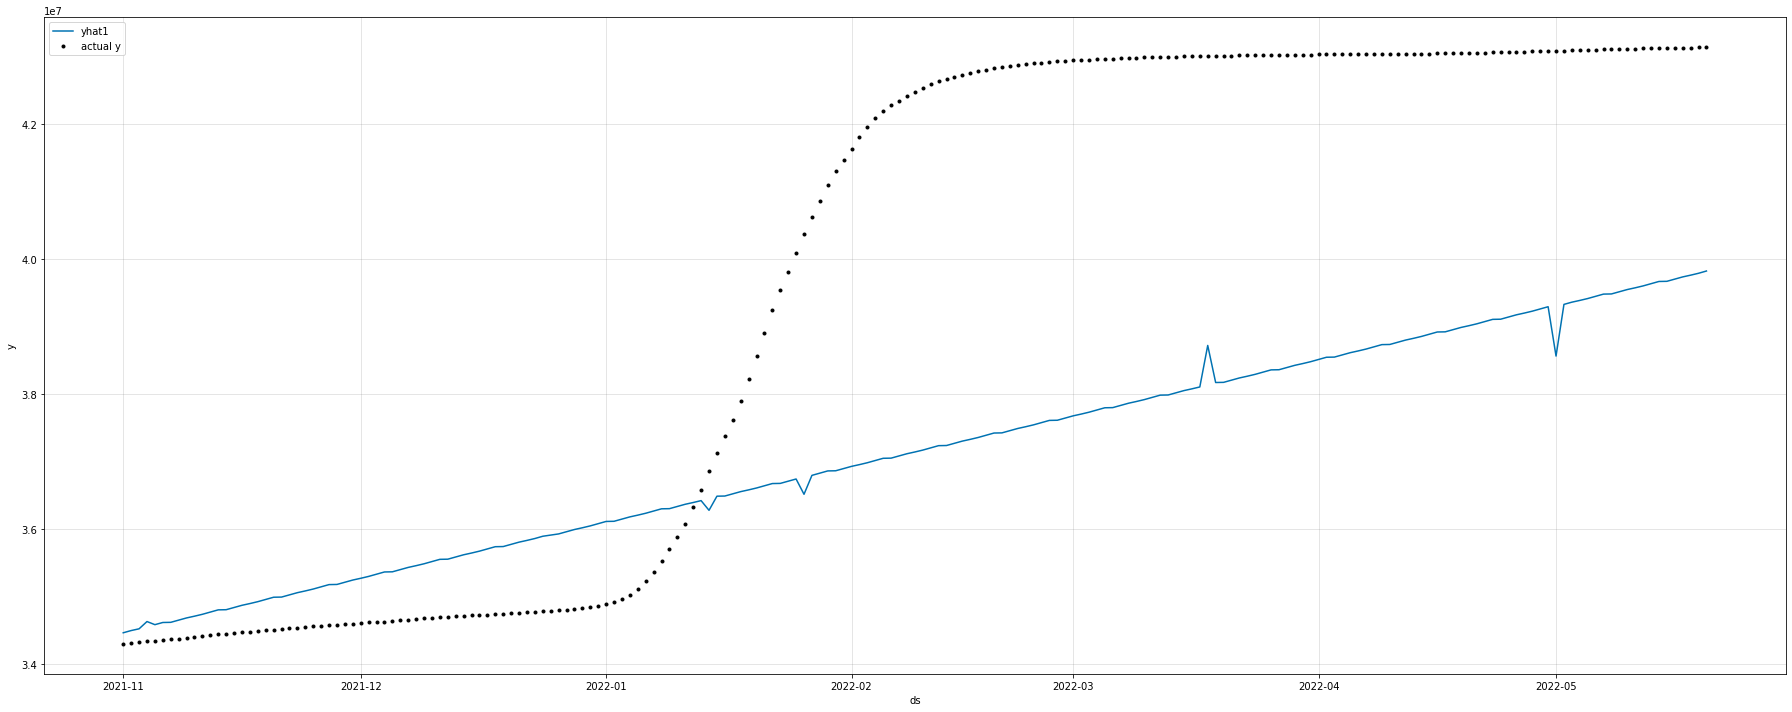

In [77]:
forecasting_results = pd.DataFrame(columns=["Country", "Model", "MAE", "RMSE", "RRSE", "MAPE"])

# US
us_start_date = "2020-01-27"
forecasting_results = nprophet_forecasting(country_list[7], country_iso_code_list[7], data_type_list[0], us_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# ES
es_start_date = "2020-02-06"
forecasting_results = nprophet_forecasting(country_list[1], country_iso_code_list[1], data_type_list[0], es_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# IT
it_start_date = "2020-02-05"
forecasting_results = nprophet_forecasting(country_list[4], country_iso_code_list[4], data_type_list[0], it_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# FR
fr_start_date = "2020-01-29"
forecasting_results = nprophet_forecasting(country_list[2], country_iso_code_list[2], data_type_list[0], fr_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# DE
de_start_date = "2020-02-01"
forecasting_results = nprophet_forecasting(country_list[0], country_iso_code_list[0], data_type_list[0], de_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# RU
ru_start_date = "2020-02-05"
forecasting_results = nprophet_forecasting(country_list[5], country_iso_code_list[5], data_type_list[0], ru_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# TR
tr_start_date = "2020-03-16"
forecasting_results = nprophet_forecasting(country_list[6], country_iso_code_list[6], data_type_list[0], tr_start_date, "2022-05-20", "2021-11-01", forecasting_results)

# IN
in_start_date = "2020-02-04"
forecasting_results = nprophet_forecasting(country_list[3], country_iso_code_list[3], data_type_list[0], in_start_date, "2022-05-20", "2021-11-01", forecasting_results)

In [76]:
forecasting_results.to_csv('/home/vladimir/GoogleDrive/Courses/03Third_semester/projects/dsa-project/data/performance_forecasting_results_confirmed_cases_neuralprophet.csv', index=False)

In [78]:
forecasting_results

,Country,Model,MAE,RMSE,RRSE,MAPE
0,United States,Neural Prophet,10766036.409,12936593.412,1.065,14.098
1,Spain,Neural Prophet,2944906.78,3536312.331,1.26,27.95
2,Italy,Neural Prophet,5413058.424,6817306.627,1.259,40.243
3,France,Neural Prophet,9431161.81,11823367.835,1.26,41.666
4,Germany,Neural Prophet,8429708.777,10977222.059,1.301,49.856
5,Russia,Neural Prophet,3126997.804,3957057.666,1.169,19.7
6,Turkey,Neural Prophet,1752018.328,2225121.412,0.996,12.606
7,India,Neural Prophet,2961140.111,3532984.69,1.219,7.082
